In [2]:
import os
import pandas as pd
import numpy as np
from skimage.io import imsave
from skimage.io import imread as imread_sk
from skimage.measure import regionprops_table
from skimage.segmentation import clear_border
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

from helper_functions import labels_from_df

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [3]:
df_path = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\230117_exp_summary.pkl'

dna_mask_dir = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_DNA_4'
cd44_mask_dir = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_CD44'

dna_mask_corr_dir = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4'
cd44_mask_corr_dir = r'D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44'

In [4]:
try:
    os.mkdir(dna_mask_corr_dir)
except:
    print('Output directory exists.')

try:
    os.mkdir(cd44_mask_corr_dir)
except:
    print('Output directory exists.')

Output directory exists.
Output directory exists.


In [5]:
df = pd.read_pickle(df_path)

In [6]:
df

,file_name,exp_dir,im_path,slide,well,exp,marker,dye,im_round,density,donor,treatment
0,T3737_9_2_1.0.4_R000_Cy3_CycB1-AF555_FINAL_AFR...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_C...,T3737_9_2,R000,T3737_9_2_R000,CycB1,Cy3,1,150,D1,0
1,T3737_9_2_1.0.4_R000_Cy5_CD8a-AF647_FINAL_AFR_...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_C...,T3737_9_2,R000,T3737_9_2_R000,CD8a,Cy5,1,150,D1,0
2,T3737_9_2_1.0.4_R000_Cy7_CD44-AF750_FINAL_AFR_...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_C...,T3737_9_2,R000,T3737_9_2_R000,CD44,Cy7,1,150,D1,0
3,T3737_9_2_1.0.4_R000_DAPI__FINAL_F.tif,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_D...,T3737_9_2,R000,T3737_9_2_R000,DNA_01,DAPI,1,150,D1,0
4,T3737_9_2_1.0.4_R000_FITC_PCNA-AF488_FINAL_AFR...,D:\data\T3737_9_2_Final,D:\data\T3737_9_2_Final\T3737_9_2_1.0.4_R000_F...,T3737_9_2,R000,T3737_9_2_R000,PCNA,FITC,1,150,D1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
315,T3937_39_4.0.4_R007_Cy3_p21-AF555_FINAL_AFR_F.tif,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_Cy3...,T3937_39,R007,T3937_39_R007,p21,Cy3,4,200,D2,24
316,T3937_39_4.0.4_R007_Cy5_FoxP3-AF647_FINAL_AFR_...,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_Cy5...,T3937_39,R007,T3937_39_R007,FoxP3,Cy5,4,200,D2,24
317,T3937_39_4.0.4_R007_Cy7_cycB2-AF750_FINAL_AFR_...,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_Cy7...,T3937_39,R007,T3937_39_R007,cycB2,Cy7,4,200,D2,24
318,T3937_39_4.0.4_R007_DAPI__FINAL_F.tif,D:\data\T3937_39_Final,D:\data\T3937_39_Final\T3937_39_4.0.4_R007_DAP...,T3937_39,R007,T3937_39_R007,DNA_04,DAPI,4,200,D2,24


In [26]:
to_segment = list(set(df.exp))
to_segment.sort()
to_segment

['T3737_9_2_R000',
 'T3737_9_2_R001',
 'T3737_9_2_R002',
 'T3737_9_2_R003',
 'T3737_9_2_R004',
 'T3737_9_2_R005',
 'T3737_9_2_R006',
 'T3737_9_2_R007',
 'T3937_39_R000',
 'T3937_39_R001',
 'T3937_39_R002',
 'T3937_39_R003',
 'T3937_39_R004',
 'T3937_39_R005',
 'T3937_39_R006',
 'T3937_39_R007']

In [7]:
properties = ['label','centroid','bbox','area','solidity','eccentricity','image','mean_intensity']

T3737_9_2_R000
Total number of nuclear objects: 12472
Total number of cyto objects: 15760
Number of nuclear objects that passed shaped selection: 12472
Number of cyto objects that passed shaped selection: 15760
Number of nuclear objects with a matching partner: 12472
Number of cyto objects with a matching partner: 15760


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 9292
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 9292


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3737_9_2_4.0.4_R000_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3737_9_2_1.0.4_R000_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


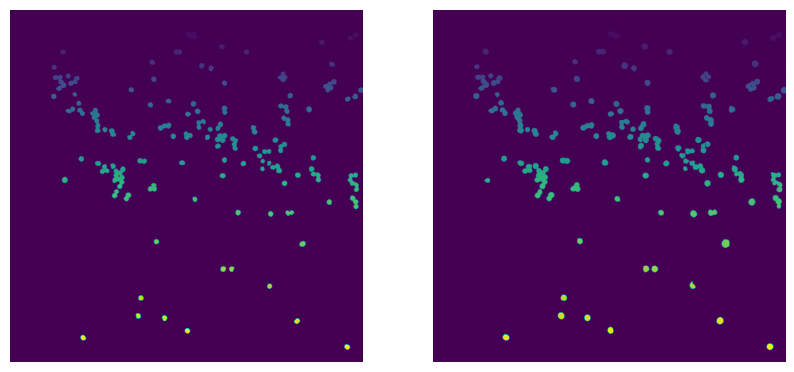

T3737_9_2_R001
Total number of nuclear objects: 27384
Total number of cyto objects: 28840
Number of nuclear objects that passed shaped selection: 27384
Number of cyto objects that passed shaped selection: 28840
Number of nuclear objects with a matching partner: 27384
Number of cyto objects with a matching partner: 28840


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 21643
Number of cyto objects that matched to more than 1 nuclear object: 1
Number of accepted pairs: 21642


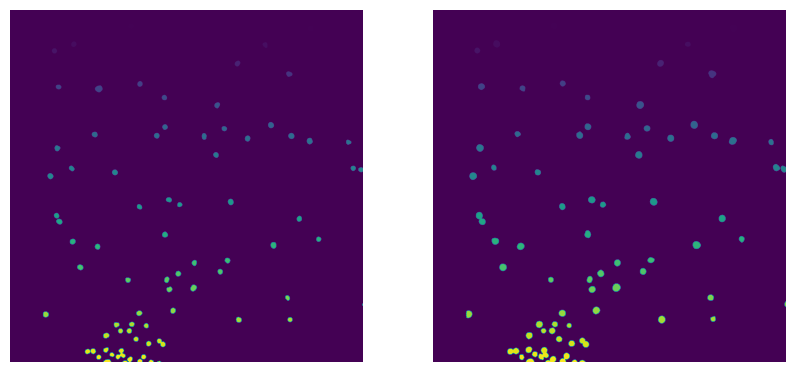

T3737_9_2_R002
Total number of nuclear objects: 17935
Total number of cyto objects: 17717
Number of nuclear objects that passed shaped selection: 17935
Number of cyto objects that passed shaped selection: 17717
Number of nuclear objects with a matching partner: 17935
Number of cyto objects with a matching partner: 17717


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 15490
Number of cyto objects that matched to more than 1 nuclear object: 2
Number of accepted pairs: 15488


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3737_9_2_4.0.4_R002_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)


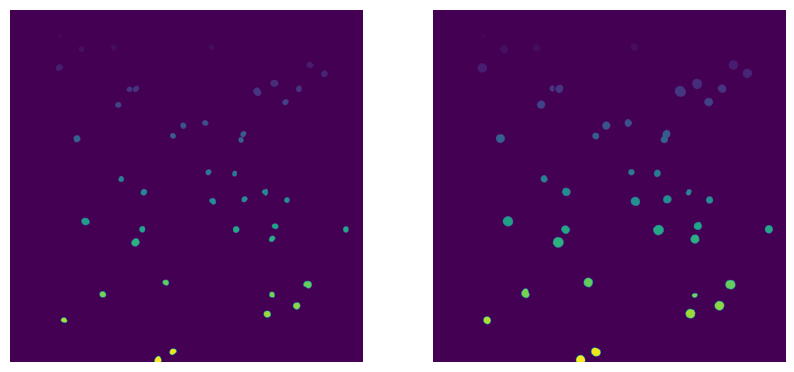

T3737_9_2_R003
Total number of nuclear objects: 16181
Total number of cyto objects: 15866
Number of nuclear objects that passed shaped selection: 16181
Number of cyto objects that passed shaped selection: 15866
Number of nuclear objects with a matching partner: 16181
Number of cyto objects with a matching partner: 15866


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 13550
Number of cyto objects that matched to more than 1 nuclear object: 2
Number of accepted pairs: 13548


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3737_9_2_4.0.4_R003_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)


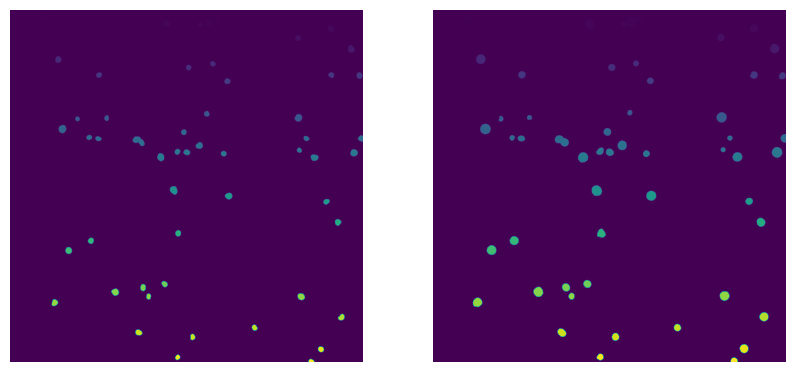

T3737_9_2_R004
Total number of nuclear objects: 11021
Total number of cyto objects: 12513
Number of nuclear objects that passed shaped selection: 11021
Number of cyto objects that passed shaped selection: 12513
Number of nuclear objects with a matching partner: 11021
Number of cyto objects with a matching partner: 12513


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 9091
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 9091


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3737_9_2_4.0.4_R004_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)


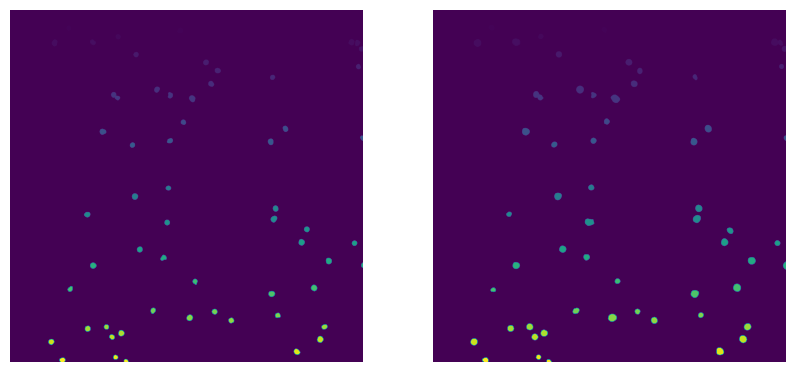

T3737_9_2_R005
Total number of nuclear objects: 35713
Total number of cyto objects: 40093
Number of nuclear objects that passed shaped selection: 35713
Number of cyto objects that passed shaped selection: 40093
Number of nuclear objects with a matching partner: 35713
Number of cyto objects with a matching partner: 40093


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 30948
Number of cyto objects that matched to more than 1 nuclear object: 1
Number of accepted pairs: 30947


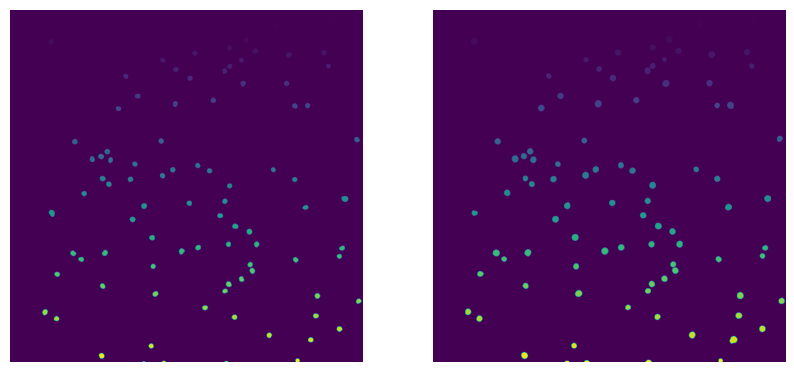

T3737_9_2_R006
Total number of nuclear objects: 18374
Total number of cyto objects: 16889
Number of nuclear objects that passed shaped selection: 18374
Number of cyto objects that passed shaped selection: 16889
Number of nuclear objects with a matching partner: 18374
Number of cyto objects with a matching partner: 16889


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 13969
Number of cyto objects that matched to more than 1 nuclear object: 1
Number of accepted pairs: 13968


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3737_9_2_4.0.4_R006_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)


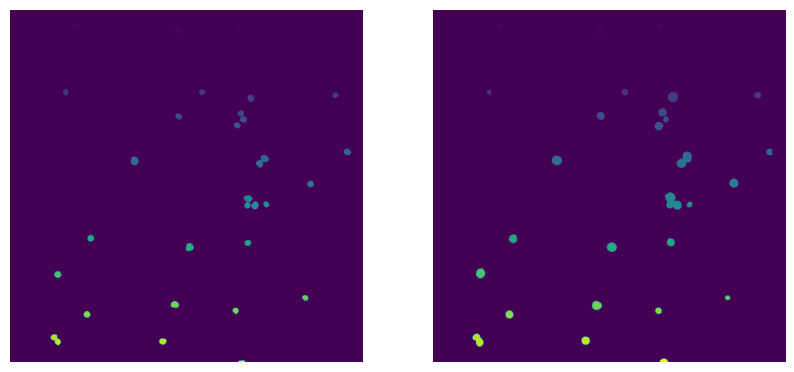

T3737_9_2_R007
Total number of nuclear objects: 12964
Total number of cyto objects: 14037
Number of nuclear objects that passed shaped selection: 12964
Number of cyto objects that passed shaped selection: 14037
Number of nuclear objects with a matching partner: 12964
Number of cyto objects with a matching partner: 14037


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 7138
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 7138


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3737_9_2_4.0.4_R007_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3737_9_2_1.0.4_R007_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


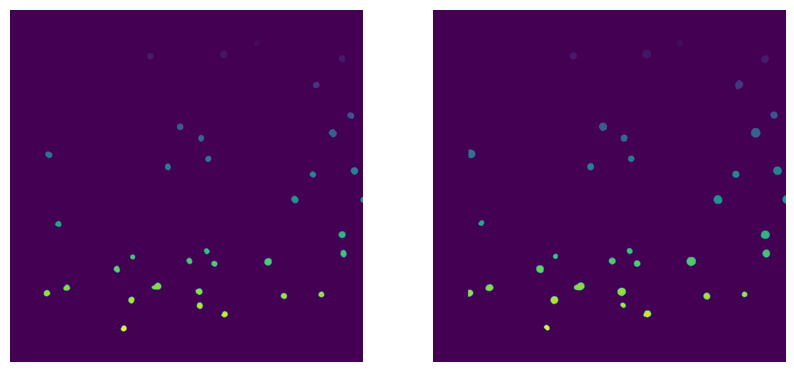

T3937_39_R000
Total number of nuclear objects: 19969
Total number of cyto objects: 18737
Number of nuclear objects that passed shaped selection: 19969
Number of cyto objects that passed shaped selection: 18737
Number of nuclear objects with a matching partner: 19969
Number of cyto objects with a matching partner: 18737


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 16940
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 16940


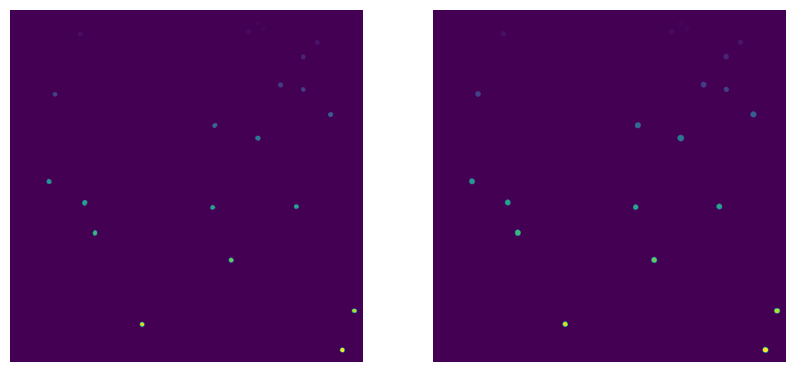

T3937_39_R001
Total number of nuclear objects: 27034
Total number of cyto objects: 27221
Number of nuclear objects that passed shaped selection: 27034
Number of cyto objects that passed shaped selection: 27221
Number of nuclear objects with a matching partner: 27034
Number of cyto objects with a matching partner: 27221


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 25057
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 25057


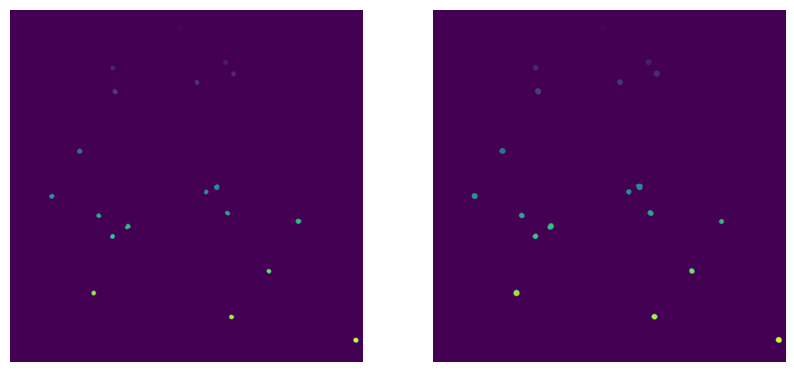

T3937_39_R002
Total number of nuclear objects: 15711
Total number of cyto objects: 22178
Number of nuclear objects that passed shaped selection: 15711
Number of cyto objects that passed shaped selection: 22178
Number of nuclear objects with a matching partner: 15711
Number of cyto objects with a matching partner: 22178


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 14054
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 14054


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R002_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R002_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


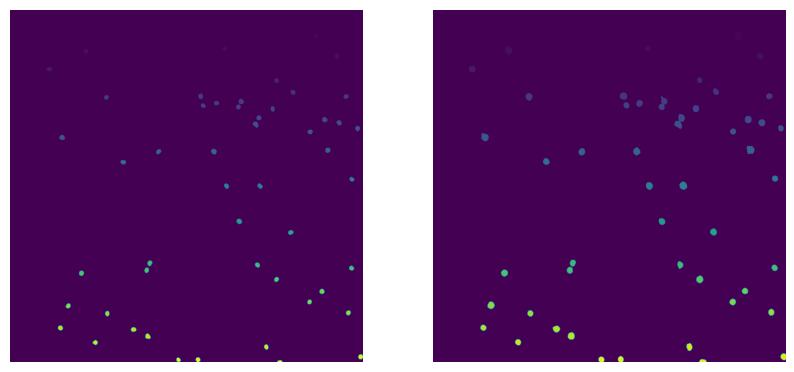

T3937_39_R003
Total number of nuclear objects: 20873
Total number of cyto objects: 21950
Number of nuclear objects that passed shaped selection: 20873
Number of cyto objects that passed shaped selection: 21950
Number of nuclear objects with a matching partner: 20873
Number of cyto objects with a matching partner: 21950


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 18644
Number of cyto objects that matched to more than 1 nuclear object: 3
Number of accepted pairs: 18641


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R003_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)


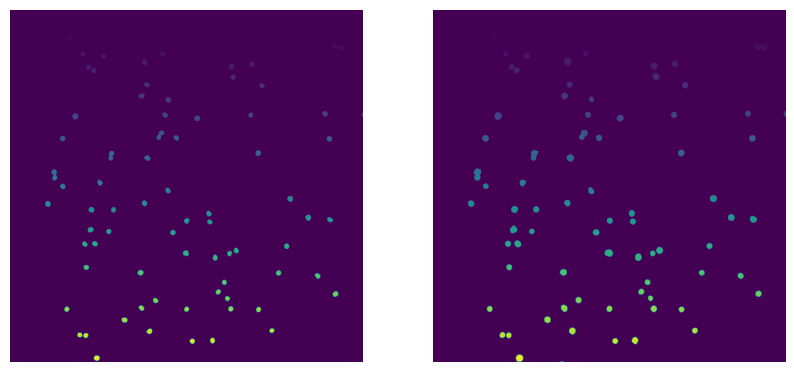

T3937_39_R004
Total number of nuclear objects: 4396
Total number of cyto objects: 4135
Number of nuclear objects that passed shaped selection: 4396
Number of cyto objects that passed shaped selection: 4135
Number of nuclear objects with a matching partner: 4396
Number of cyto objects with a matching partner: 4135
Number of nuclear objects that match to cyto objects: 993
Number of cyto objects that matched to more than 1 nuclear object: 1
Number of accepted pairs: 992


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R004_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R004_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


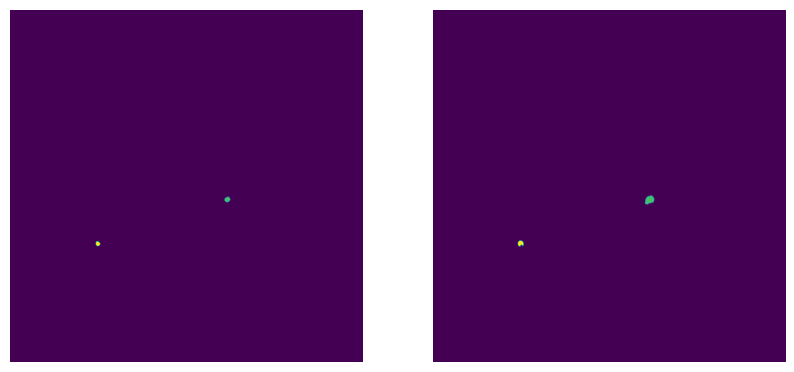

T3937_39_R005
Total number of nuclear objects: 5883
Total number of cyto objects: 5981
Number of nuclear objects that passed shaped selection: 5883
Number of cyto objects that passed shaped selection: 5981
Number of nuclear objects with a matching partner: 5883
Number of cyto objects with a matching partner: 5981


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 5699
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 5699


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R005_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R005_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


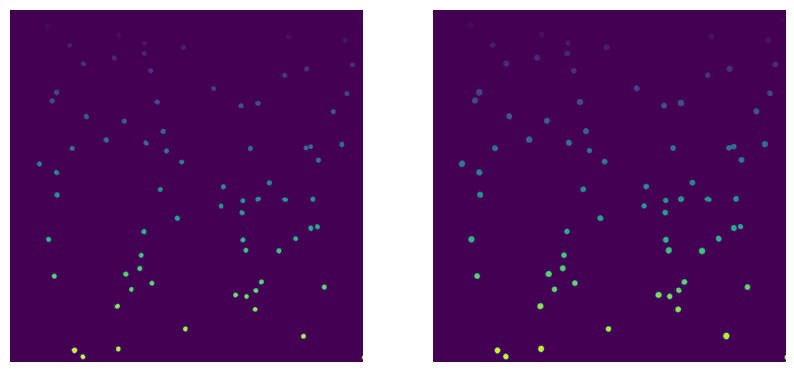

T3937_39_R006
Total number of nuclear objects: 2262
Total number of cyto objects: 15533
Number of nuclear objects that passed shaped selection: 2262
Number of cyto objects that passed shaped selection: 15533
Number of nuclear objects with a matching partner: 2262
Number of cyto objects with a matching partner: 15533
Number of nuclear objects that match to cyto objects: 453
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 453


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R006_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R006_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


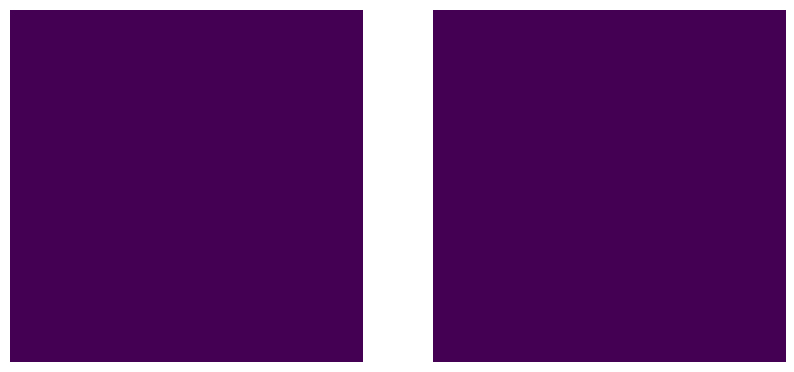

T3937_39_R007
Total number of nuclear objects: 4831
Total number of cyto objects: 27913
Number of nuclear objects that passed shaped selection: 4831
Number of cyto objects that passed shaped selection: 27913
Number of nuclear objects with a matching partner: 4831
Number of cyto objects with a matching partner: 27913
Number of nuclear objects that match to cyto objects: 551
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 551


C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R007_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_15808\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R007_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


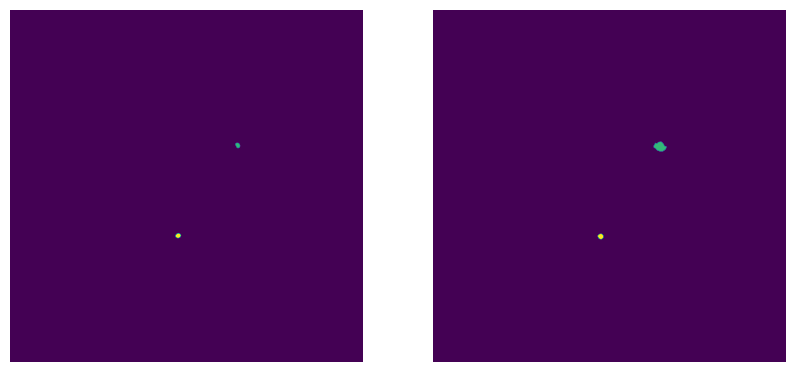

In [27]:
for exp_sel in to_segment:

    print(exp_sel)

    df_sel = df.loc[df.exp==exp_sel,:]

    # open mask images
    dna_im_name = df_sel.loc[df_sel.marker=='DNA_04','file_name'].tolist()[0]
    dna_mask_path = os.path.join(dna_mask_dir,dna_im_name.replace('.tif','_maskdna4.png'))

    cd44_im_name = df_sel.loc[df_sel.marker=='CD44','file_name'].tolist()[0]
    cd44_mask_path = os.path.join(cd44_mask_dir,cd44_im_name.replace('.tif','_maskcd44.png'))

    dna_mask = imread_sk(dna_mask_path)
    cd44_mask = imread_sk(cd44_mask_path)

    # get shape of the mask
    im_shape = dna_mask.shape

    # clear border objects
    dna_mask_clean = clear_border(dna_mask,buffer_size=1)
    cd44_mask_clean = clear_border(cd44_mask,buffer_size=1)

    # calculate properties
    dna_data = regionprops_table(dna_mask_clean,intensity_image=(cd44_mask_clean>0),properties=properties)
    df_dna = pd.DataFrame(dna_data)
    print(f'Total number of nuclear objects: {len(df_dna)}')

    cd44_data = regionprops_table(cd44_mask_clean,intensity_image=(dna_mask_clean>0),properties=properties)
    df_cd44 = pd.DataFrame(cd44_data)
    print(f'Total number of cyto objects: {len(df_cd44)}')

    # select objects based on the shape characteristics
    df_dna_sel = df_dna.loc[((df_dna.area > 250) & (df_dna.area < 1000)),:]
    df_dna_sel = df_dna_sel.loc[(df_dna_sel.eccentricity < 0.75),:]
    df_dna_sel = df_dna_sel.loc[(df_dna_sel.solidity > 0.9),:]
    print(f'Number of nuclear objects that passed shaped selection: {len(df_dna)}')

    df_cd44_sel = df_cd44.loc[((df_cd44.area > 250) & (df_cd44.area < 2000)),:]
    df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.eccentricity < 0.75),:]
    df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.solidity > 0.8),:]
    print(f'Number of cyto objects that passed shaped selection: {len(df_cd44)}')

    # select objects based on the presence of matching partner
    df_dna_sel = df_dna_sel.loc[(df_dna_sel.mean_intensity > 0.6),:]
    print(f'Number of nuclear objects with a matching partner: {len(df_dna)}')

    df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.mean_intensity > 0.2),:]
    print(f'Number of cyto objects with a matching partner: {len(df_cd44)}')

    # match objects
    dist_mat = distance_matrix(df_dna_sel.loc[:,['centroid-0','centroid-1']],df_cd44_sel.loc[:,['centroid-0','centroid-1']])

    # choose dna objects that have only one close cyto object
    dist_mat_bin = dist_mat < 10
    dna_to_cyto_match = np.sum(dist_mat_bin,axis=1)
    sel_vec = (dna_to_cyto_match==1)

    df_dna_match = df_dna_sel.loc[sel_vec,:]

    # find label of the matching cyto object
    dna_min_partner_iloc = np.argmin(dist_mat,axis=1)
    dna_min_partner_label = np.array(df_cd44_sel.label.tolist())[dna_min_partner_iloc][sel_vec]
    df_dna_match['cyto_match'] = dna_min_partner_label

    print(f'Number of nuclear objects that match to cyto objects: {len(df_dna_match)}')

    # look for cyto that matched to more than one dna
    print(f'Number of cyto objects that matched to more than 1 nuclear object: {np.sum(df_dna_match.cyto_match.duplicated())}')

    df_dna_match = df_dna_match.drop(df_dna_match.index[df_dna_match.cyto_match.duplicated()])

    print(f'Number of accepted pairs: {len(df_dna_match)}')

    # merge 
    df1 = df_dna_match.loc[:,['image','cyto_match','bbox-0','bbox-1','bbox-2','bbox-3']]
    df2 = df_cd44_sel.loc[:,['image','label','bbox-0','bbox-1','bbox-2','bbox-3']]

    df_obj = pd.merge(left=df1,right=df2,left_on='cyto_match',right_on='label',how='inner',suffixes=('_nuc','_cyto'))

    df_obj['label'] = df_obj.index+1

    # create labels
    dna_sel_labels = labels_from_df(df_obj,im_shape = im_shape,label='label',image='image_nuc',bbox_suffix='_nuc')
    cd44_sel_labels = labels_from_df(df_obj,im_shape = im_shape,label='label',image='image_cyto',bbox_suffix='_cyto')

    # save labels
    dna_mask_path = os.path.join(dna_mask_corr_dir,dna_im_name.replace('.tif','_maskdna4_corr.png'))
    imsave(dna_mask_path,dna_sel_labels)

    cd44_mask_path = os.path.join(cd44_mask_corr_dir,cd44_im_name.replace('.tif','_maskcd44_corr.png'))
    imsave(cd44_mask_path,cd44_sel_labels)

    # display sample
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(dna_sel_labels[:1500,:1500])
    axes[0].set_axis_off()
    axes[1].imshow(cd44_sel_labels[:1500,:1500])
    axes[1].set_axis_off()

    plt.show()

In [8]:
to_segment = ['T3937_39_R004','T3937_39_R006','T3937_39_R007']

T3937_39_R004
Total number of nuclear objects: 4376
Total number of cyto objects: 4292
Number of nuclear objects that passed shaped selection: 4376
Number of cyto objects that passed shaped selection: 4292
Number of nuclear objects with a matching partner: 4376
Number of cyto objects with a matching partner: 4292


C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 3649
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 3649


C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R004_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R004_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


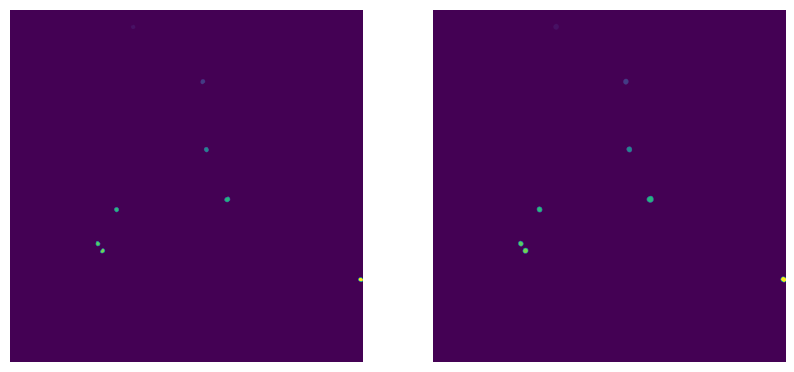

T3937_39_R006
Total number of nuclear objects: 2112
Total number of cyto objects: 2638
Number of nuclear objects that passed shaped selection: 2112
Number of cyto objects that passed shaped selection: 2638
Number of nuclear objects with a matching partner: 2112
Number of cyto objects with a matching partner: 2638
Number of nuclear objects that match to cyto objects: 1496
Number of cyto objects that matched to more than 1 nuclear object: 0
Number of accepted pairs: 1496


C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label
C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R006_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R006_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


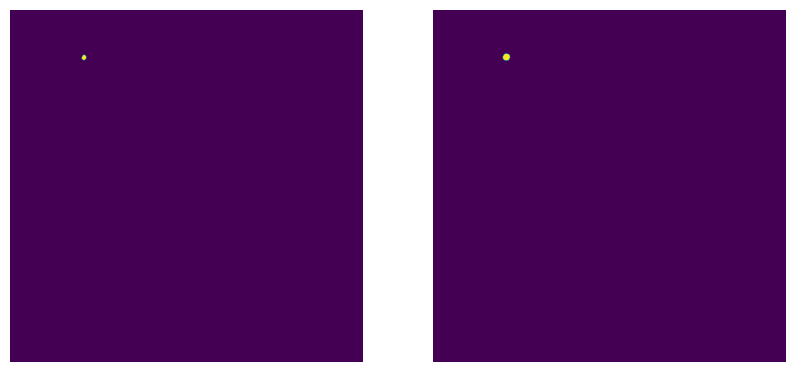

T3937_39_R007
Total number of nuclear objects: 4429
Total number of cyto objects: 4257
Number of nuclear objects that passed shaped selection: 4429
Number of cyto objects that passed shaped selection: 4257
Number of nuclear objects with a matching partner: 4429
Number of cyto objects with a matching partner: 4257


C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dna_match['cyto_match'] = dna_min_partner_label


Number of nuclear objects that match to cyto objects: 3659
Number of cyto objects that matched to more than 1 nuclear object: 1
Number of accepted pairs: 3658


C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:89: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_DNA_4\T3937_39_4.0.4_R007_DAPI__FINAL_F_maskdna4_corr.png is a low contrast image
  imsave(dna_mask_path,dna_sel_labels)
C:\Users\Stallab\AppData\Local\Temp\ipykernel_27644\4001814883.py:92: UserWarning: D:\data_analysis\Betsy_Suraj\230112_Tcell_analysis\segmentation_corr_CD44\T3937_39_1.0.4_R007_Cy7_CD44-AF750_FINAL_AFR_F_maskcd44_corr.png is a low contrast image
  imsave(cd44_mask_path,cd44_sel_labels)


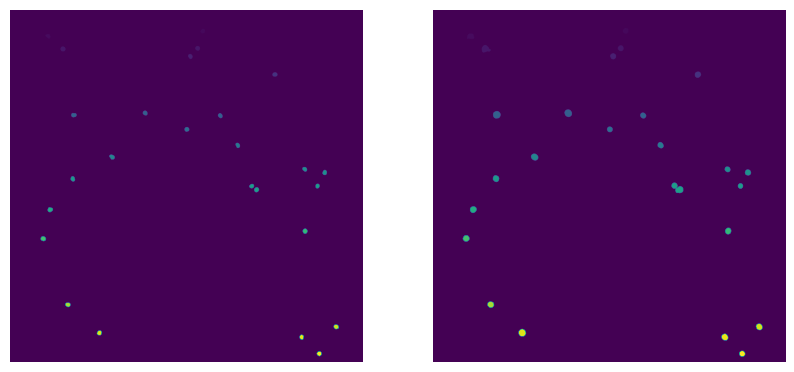

In [9]:
for exp_sel in to_segment:

    print(exp_sel)

    df_sel = df.loc[df.exp==exp_sel,:]

    # open mask images
    dna_im_name = df_sel.loc[df_sel.marker=='DNA_04','file_name'].tolist()[0]
    dna_mask_path = os.path.join(dna_mask_dir,dna_im_name.replace('.tif','_maskdna4.png'))

    cd44_im_name = df_sel.loc[df_sel.marker=='CD44','file_name'].tolist()[0]
    cd44_mask_path = os.path.join(cd44_mask_dir,cd44_im_name.replace('.tif','_maskcd44.png'))

    dna_mask = imread_sk(dna_mask_path)
    cd44_mask = imread_sk(cd44_mask_path)

    # get shape of the mask
    im_shape = dna_mask.shape

    # clear border objects
    dna_mask_clean = clear_border(dna_mask,buffer_size=1)
    cd44_mask_clean = clear_border(cd44_mask,buffer_size=1)

    # calculate properties
    dna_data = regionprops_table(dna_mask_clean,intensity_image=(cd44_mask_clean>0),properties=properties)
    df_dna = pd.DataFrame(dna_data)
    print(f'Total number of nuclear objects: {len(df_dna)}')

    cd44_data = regionprops_table(cd44_mask_clean,intensity_image=(dna_mask_clean>0),properties=properties)
    df_cd44 = pd.DataFrame(cd44_data)
    print(f'Total number of cyto objects: {len(df_cd44)}')

    # select objects based on the shape characteristics
    df_dna_sel = df_dna.loc[((df_dna.area > 250) & (df_dna.area < 1000)),:]
    df_dna_sel = df_dna_sel.loc[(df_dna_sel.eccentricity < 0.75),:]
    df_dna_sel = df_dna_sel.loc[(df_dna_sel.solidity > 0.9),:]
    print(f'Number of nuclear objects that passed shaped selection: {len(df_dna)}')

    df_cd44_sel = df_cd44.loc[((df_cd44.area > 250) & (df_cd44.area < 2000)),:]
    df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.eccentricity < 0.75),:]
    df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.solidity > 0.8),:]
    print(f'Number of cyto objects that passed shaped selection: {len(df_cd44)}')

    # select objects based on the presence of matching partner
    df_dna_sel = df_dna_sel.loc[(df_dna_sel.mean_intensity > 0.6),:]
    print(f'Number of nuclear objects with a matching partner: {len(df_dna)}')

    df_cd44_sel = df_cd44_sel.loc[(df_cd44_sel.mean_intensity > 0.2),:]
    print(f'Number of cyto objects with a matching partner: {len(df_cd44)}')

    # match objects
    dist_mat = distance_matrix(df_dna_sel.loc[:,['centroid-0','centroid-1']],df_cd44_sel.loc[:,['centroid-0','centroid-1']])

    # choose dna objects that have only one close cyto object
    dist_mat_bin = dist_mat < 10
    dna_to_cyto_match = np.sum(dist_mat_bin,axis=1)
    sel_vec = (dna_to_cyto_match==1)

    df_dna_match = df_dna_sel.loc[sel_vec,:]

    # find label of the matching cyto object
    dna_min_partner_iloc = np.argmin(dist_mat,axis=1)
    dna_min_partner_label = np.array(df_cd44_sel.label.tolist())[dna_min_partner_iloc][sel_vec]
    df_dna_match['cyto_match'] = dna_min_partner_label

    print(f'Number of nuclear objects that match to cyto objects: {len(df_dna_match)}')

    # look for cyto that matched to more than one dna
    print(f'Number of cyto objects that matched to more than 1 nuclear object: {np.sum(df_dna_match.cyto_match.duplicated())}')

    df_dna_match = df_dna_match.drop(df_dna_match.index[df_dna_match.cyto_match.duplicated()])

    print(f'Number of accepted pairs: {len(df_dna_match)}')

    # merge 
    df1 = df_dna_match.loc[:,['image','cyto_match','bbox-0','bbox-1','bbox-2','bbox-3']]
    df2 = df_cd44_sel.loc[:,['image','label','bbox-0','bbox-1','bbox-2','bbox-3']]

    df_obj = pd.merge(left=df1,right=df2,left_on='cyto_match',right_on='label',how='inner',suffixes=('_nuc','_cyto'))

    df_obj['label'] = df_obj.index+1

    # create labels
    dna_sel_labels = labels_from_df(df_obj,im_shape = im_shape,label='label',image='image_nuc',bbox_suffix='_nuc')
    cd44_sel_labels = labels_from_df(df_obj,im_shape = im_shape,label='label',image='image_cyto',bbox_suffix='_cyto')

    # save labels
    dna_mask_path = os.path.join(dna_mask_corr_dir,dna_im_name.replace('.tif','_maskdna4_corr.png'))
    imsave(dna_mask_path,dna_sel_labels)

    cd44_mask_path = os.path.join(cd44_mask_corr_dir,cd44_im_name.replace('.tif','_maskcd44_corr.png'))
    imsave(cd44_mask_path,cd44_sel_labels)

    # display sample
    fig,axes = plt.subplots(1,2,figsize=(10,5))
    axes[0].imshow(dna_sel_labels[:1500,:1500])
    axes[0].set_axis_off()
    axes[1].imshow(cd44_sel_labels[:1500,:1500])
    axes[1].set_axis_off()

    plt.show()